In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from datetime import datetime

# ----------------------------
# 1. Data Loading and Preprocessing
# ----------------------------
df = pd.read_csv('../data/weekly_df_with_tickers.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['risk_premium'])
df.sort_values(['Ticker', 'Date'], inplace=True)

# Compute the lagged risk premium for each ticker individually.
df['risk_premium_lag'] = df.groupby('Ticker')['risk_premium'].shift(1)

# Create lagged risk premium for Random Walk prediction

df.dropna(subset=['risk_premium_lag'], inplace=True)

# ----------------------------
# 2. Define the Rolling Window Forecast Function (Random Walk)
# ----------------------------
def rolling_window_forecast_rw(df, initial_train_start, initial_train_end,
                               validation_window_years=1, rolling_step=1):
    """
    Performs rolling window forecasting using a Random Walk model and returns both a summary of each window
    and detailed results with year, actual, and predicted values.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset (must have a DateTimeIndex, and columns 'risk_premium' and 'risk_premium_lag')
    initial_train_start : str or datetime
        Start date of the initial training period
    initial_train_end : str or datetime
        End date of the initial training period
    validation_window_years : int, default 1
        The length of the validation period (in years)
    rolling_step : int, default 1
        The number of years to shift the window for each iteration

    Returns:
    --------
    summary_results : list of dicts
        A summary of each rolling window including train/validation dates and R² score
    detailed_results_df : pandas.DataFrame
        Detailed results DataFrame with columns: year, actual, and predicted values for the validation period
    """
    summary_results = []
    detailed_results = []  # Used to store detailed validation results for each window

    # Convert dates to Timestamp objects
    train_start = pd.to_datetime(initial_train_start)
    train_end = pd.to_datetime(initial_train_end)
    val_start = train_end + pd.DateOffset(days=1)
    val_end = val_start + pd.DateOffset(years=validation_window_years) - pd.DateOffset(days=1)

    max_date = df.index.max()

    # Random Walk prediction: use the previous period's risk premium as the prediction
    feature_col = 'risk_premium_lag'

    while train_start < max_date:
        # Adjust the validation end date if it exceeds the available data range
        if val_end > max_date:
            val_end = max_date

        # Get the current window's training and validation data
        train_data = df.loc[(df.index >= train_start) & (df.index <= train_end)]
        val_data = df.loc[(df.index >= val_start) & (df.index <= val_end)]
        if train_data.empty or val_data.empty:
            break

        # For Random Walk, the validation prediction is simply the lagged risk premium
        y_val = val_data['risk_premium']
        # Use the lagged risk premium (which represents t-1) as the prediction
        y_pred = val_data[feature_col]

        # Compute R² score
        overall_r2 = r2_score(y_val, y_pred)

        # Record summary information (model parameters are not applicable here)
        summary_results.append({
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end,
            'overall_r2': overall_r2,
            'model': 'Random Walk'
        })

        print(f"Train: {train_start.date()} to {train_end.date()} | "
              f"Validation: {val_start.date()} to {val_end.date()} | "
              f"Overall R²: {overall_r2:.4f} | Model: Random Walk")

        # Save detailed validation results: each date's year, actual value, and predicted value
        df_detail = pd.DataFrame({
            'year': val_data.index.year,
            'actual': y_val.values,
            'predicted': y_pred.values
        }, index=val_data.index)
        detailed_results.append(df_detail)

        # Update the window (shift each boundary forward by rolling_step years)
        train_start += pd.DateOffset(years=rolling_step)
        train_end += pd.DateOffset(years=rolling_step)
        val_start += pd.DateOffset(years=rolling_step)
        val_end += pd.DateOffset(years=rolling_step)

    # Concatenate all detailed validation results
    if detailed_results:
        detailed_results_df = pd.concat(detailed_results)
    else:
        detailed_results_df = pd.DataFrame()

    return summary_results, detailed_results_df

# ----------------------------
# 3. Run the Rolling Window Forecast for Random Walk
# ----------------------------
summary_results_rw, detailed_results_df_rw = rolling_window_forecast_rw(
    df,
    initial_train_start='1990-01-01',
    initial_train_end='2015-12-31',
    validation_window_years=1,   # validation period of 1 year
    rolling_step=1
)

# Convert summary results to a DataFrame
results_df_rw = pd.DataFrame([{
    'train_start': r['train_start'],
    'train_end': r['train_end'],
    'val_start': r['val_start'],
    'val_end': r['val_end'],
    'overall_r2': r['overall_r2'],
    'model': r['model']
} for r in summary_results_rw])

print("\nSummary Results (Rolling Window Random Walk):")
print(results_df_rw)

print("\nDetailed Results (Year, Actual, Predicted):")
print(detailed_results_df_rw.head())

# Save the results to CSV files
results_df_rw.to_csv("rolling_window_results_rw_summary.csv", index=False)
detailed_results_df_rw = detailed_results_df_rw.reset_index(drop=True)
detailed_results_df_rw.to_csv("rolling_window_results_rw_detailed.csv", index=False)

Train: 1990-01-01 to 2015-12-31 | Validation: 2016-01-01 to 2016-12-31 | Overall R²: -1.0281 | Model: Random Walk
Train: 1991-01-01 to 2016-12-31 | Validation: 2017-01-01 to 2017-12-31 | Overall R²: -0.9757 | Model: Random Walk
Train: 1992-01-01 to 2017-12-31 | Validation: 2018-01-01 to 2018-12-31 | Overall R²: -1.0418 | Model: Random Walk
Train: 1993-01-01 to 2018-12-31 | Validation: 2019-01-01 to 2019-12-31 | Overall R²: -1.0621 | Model: Random Walk
Train: 1994-01-01 to 2019-12-31 | Validation: 2020-01-01 to 2020-12-31 | Overall R²: -1.2654 | Model: Random Walk
Train: 1995-01-01 to 2020-12-31 | Validation: 2021-01-01 to 2021-12-31 | Overall R²: -0.9012 | Model: Random Walk
Train: 1996-01-01 to 2021-12-31 | Validation: 2022-01-01 to 2022-12-31 | Overall R²: -0.7948 | Model: Random Walk
Train: 1997-01-01 to 2022-12-31 | Validation: 2023-01-01 to 2023-12-29 | Overall R²: -0.9621 | Model: Random Walk

Summary Results (Rolling Window Random Walk):
  train_start  train_end  val_start    va

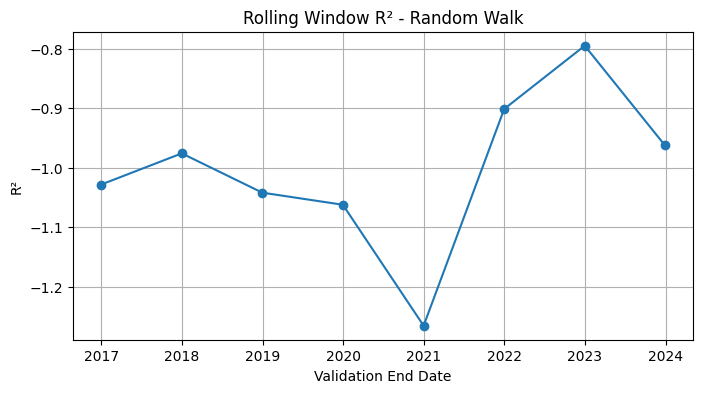

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(results_df_rw['val_end'], results_df_rw['overall_r2'], marker='o', linestyle='-')
plt.title("Rolling Window R² - Random Walk")
plt.xlabel("Validation End Date")
plt.ylabel("R²")
plt.grid(True)
plt.show()